In [199]:
# @author: Yossi_shor

import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
import platform
from keras.layers import Dense,Conv2D,MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [200]:
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))
print(os.getcwd())

Platform: Linux-4.4.0-1102-aws-x86_64-with-debian-stretch-sid
Tensorflow version: 2.0.0
Keras version: 2.3.1
/home/ubuntu/yoss_project/yoss_project_2/project


In [203]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

In [204]:
img = load_img('cat-and-dog/training_set/training_set/cats/cat.887.jpg')

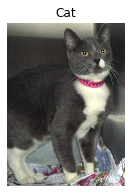

In [205]:
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Cat')
plt.show()

In [206]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

In [207]:
x.shape, x2.shape

((500, 359, 3), (1, 500, 359, 3))

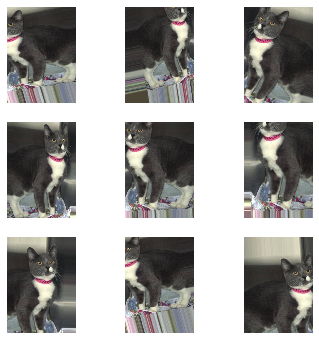

In [208]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

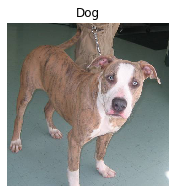

In [209]:
img = load_img('cat-and-dog/training_set/training_set/dogs/dog.1345.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Dog')
plt.show()

In [210]:
# default settings
img_width, img_height = 224, 224
train_dir = 'cat-and-dog/training_set/training_set'
validate_dir = 'cat-and-dog/test_set/test_set/'
nb_epochs = 10
batch_size = 1

In [17]:
num_classes = len(glob.glob(train_dir + '/*'))
num_classes

2

In [18]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(f"we have {nb_train_samples} images for training")

we have 8007 images for training


In [19]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(f"we have {nb_validate_samples} images for validation set")

we have 2025 images for validation set


In [216]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [217]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [218]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 8005 images belonging to 2 classes.


In [219]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 2023 images belonging to 2 classes.


In [25]:
# set up transfer learning on pre-trained ImageNet VGG16 model - remove fully connected layer and replace
# with softmax for classifying 10 classes
vgg16_model = VGG16(weights = 'imagenet', include_top = False)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)
model = Model(input = vgg16_model.input, output = predictions)

/home/ubuntu/yoss_project/yoss_project_2/yoss_envi/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [80]:
# freeze all layers of the pre-trained model
for layer in vgg16_model.layers:
    layer.trainable = False

In [81]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [86]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("vgg16_yo.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, 
                             save_weights_only = False, mode = 'auto', period = 1)

In [88]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    epochs = nb_epochs,
    steps_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    validation_steps = nb_validate_samples,
    class_weight='auto',
    callbacks = [checkpoint])
print('Training time: %s' % (now() - t))

Epoch 1/10
8007/8007 [==============================] - 530s 66ms/step - loss: 0.3912 - accuracy: 0.8406 - val_loss: 0.0589 - val_accuracy: 0.8840

Epoch 00001: val_accuracy improved from -inf to 0.88395, saving model to vgg16_yo.h5
Epoch 2/10
8007/8007 [==============================] - 541s 68ms/step - loss: 0.3545 - accuracy: 0.8670 - val_loss: 1.4275 - val_accuracy: 0.8711

Epoch 00002: val_accuracy did not improve from 0.88395
Epoch 3/10
8007/8007 [==============================] - 542s 68ms/step - loss: 0.3387 - accuracy: 0.8785 - val_loss: 0.0036 - val_accuracy: 0.7304

Epoch 00003: val_accuracy did not improve from 0.88395
Epoch 4/10
8007/8007 [==============================] - 401s 50ms/step - loss: 0.3420 - accuracy: 0.8810 - val_loss: 0.0024 - val_accuracy: 0.8938

Epoch 00004: val_accuracy improved from 0.88395 to 0.89383, saving model to vgg16_yo.h5
Epoch 5/10
8007/8007 [==============================] - 309s 39ms/step - loss: 0.3409 - accuracy: 0.8824 - val_loss: 0.0000e+

In [92]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 5.038450241088867
Test Accuracy: 0.848395049571991


In [93]:
# save transfer learning model for offline prediction purposes
model.save('vgg16_model.h5')

In [194]:
save_m = model.save_weights('vgg.h5')

In [128]:
# list all data in history
print(transfer_learning_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


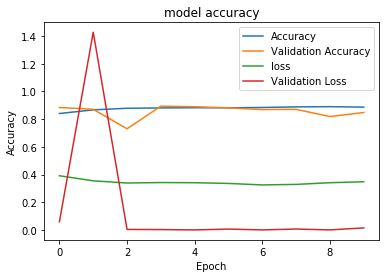

In [94]:
plt.plot(transfer_learning_history.history["accuracy"])
plt.plot(transfer_learning_history.history['val_accuracy'])
plt.plot(transfer_learning_history.history['loss'])
plt.plot(transfer_learning_history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

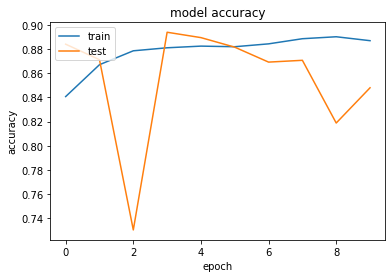

In [130]:
# summarize history for accuracy
plt.plot(transfer_learning_history.history['accuracy'])
plt.plot(transfer_learning_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

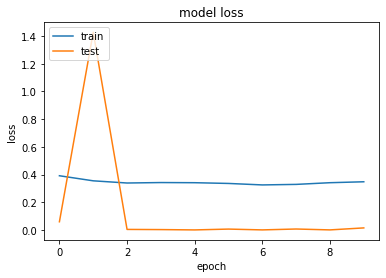

In [131]:
# summarize history for loss
plt.plot(transfer_learning_history.history['loss'])
plt.plot(transfer_learning_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [141]:
validate_generator.total_batches_seen

26353

In [26]:
predict_files = glob.glob("cat-and-dog/test_set/test_set/cats/*.jpg")

In [27]:
predict_files

['cat-and-dog/test_set/test_set/cats/cat.4597.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4988.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4715.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4439.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4142(1).jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4905.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4967.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4782.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4557.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4991.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4889.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4784.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4462.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4005.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4514.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4263.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4411.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4978.jpg',
 'cat-and-dog/test_set/test_set/cats/cat.4527.jpg',
 'cat-and

In [174]:
from keras.models import load_model
model = load_model('vgg16_model.h5')

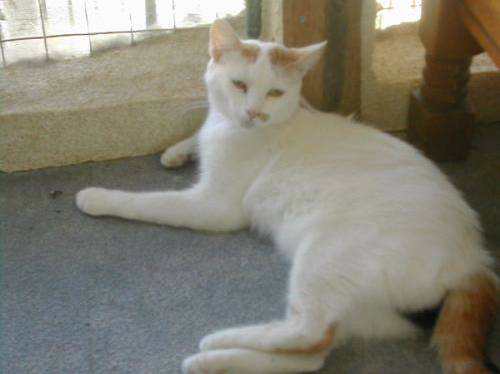

In [175]:
from keras.preprocessing import image
image.load_img(predict_files[103])

In [176]:
cv2.imread(predict_files[103]).shape

(374, 500, 3)

In [177]:
im = cv2.imread(predict_files[103])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [140]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis = 0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])
print(['Dog' if j == 1 else 'Cat' for j in predictor ])

['Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat'

In [141]:
final = pd.DataFrame()
final["id"] = image_id
final["Cats"] = predictor 
final.head(100)

,id,Cats
0,cat-and-dog/test_set/test_set/cats/cat.4597.jpg,0
1,cat-and-dog/test_set/test_set/cats/cat.4988.jpg,0
2,cat-and-dog/test_set/test_set/cats/cat.4715.jpg,0
3,cat-and-dog/test_set/test_set/cats/cat.4439.jpg,0
4,cat-and-dog/test_set/test_set/cats/cat.4142(1)...,0
...,...,...
95,cat-and-dog/test_set/test_set/cats/cat.4893.jpg,0
96,cat-and-dog/test_set/test_set/cats/cat.4771.jpg,1
97,cat-and-dog/test_set/test_set/cats/cat.4731.jpg,0
98,cat-and-dog/test_set/test_set/cats/cat.4568.jpg,0


In [45]:
!wget "https://www.guidedogs.org/wp-content/uploads/2019/11/website-donate-mobile.jpg"

--2020-03-14 18:21:04--  https://www.guidedogs.org/wp-content/uploads/2019/11/website-donate-mobile.jpg
Resolving www.guidedogs.org (www.guidedogs.org)... 192.138.21.222
Connecting to www.guidedogs.org (www.guidedogs.org)|192.138.21.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47539 (46K) [image/jpeg]
Saving to: ‘website-donate-mobile.jpg.1’

website-donate-mobi 100%[===================>]  46.42K   306KB/s    in 0.2s    

2020-03-14 18:21:04 (306 KB/s) - ‘website-donate-mobile.jpg.1’ saved [47539/47539]



In [178]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}
classes

{0: 'cats', 1: 'dogs'}

In [179]:
final["Cats"] = final["Cats"].apply(lambda x: classes[x])
final.head(100)

,id,Cats
0,cat-and-dog/test_set/test_set/cats/cat.4597.jpg,cats
1,cat-and-dog/test_set/test_set/cats/cat.4988.jpg,cats
2,cat-and-dog/test_set/test_set/cats/cat.4715.jpg,cats
3,cat-and-dog/test_set/test_set/cats/cat.4439.jpg,cats
4,cat-and-dog/test_set/test_set/cats/cat.4142(1)...,cats
...,...,...
95,cat-and-dog/test_set/test_set/cats/cat.4893.jpg,cats
96,cat-and-dog/test_set/test_set/cats/cat.4771.jpg,dogs
97,cat-and-dog/test_set/test_set/cats/cat.4731.jpg,cats
98,cat-and-dog/test_set/test_set/cats/cat.4568.jpg,cats


In [180]:
final.to_csv("vgg16_model_tl_test.csv", index = False)

In [181]:
import pandas as pd
data = pd.read_csv('vgg16_model_tl_test.csv')
data.head(10)

,id,Cats
0,cat-and-dog/test_set/test_set/cats/cat.4597.jpg,cats
1,cat-and-dog/test_set/test_set/cats/cat.4988.jpg,cats
2,cat-and-dog/test_set/test_set/cats/cat.4715.jpg,cats
3,cat-and-dog/test_set/test_set/cats/cat.4439.jpg,cats
4,cat-and-dog/test_set/test_set/cats/cat.4142(1)...,cats
5,cat-and-dog/test_set/test_set/cats/cat.4905.jpg,cats
6,cat-and-dog/test_set/test_set/cats/cat.4967.jpg,cats
7,cat-and-dog/test_set/test_set/cats/cat.4782.jpg,cats
8,cat-and-dog/test_set/test_set/cats/cat.4557.jpg,cats
9,cat-and-dog/test_set/test_set/cats/cat.4991.jpg,cats


Dog


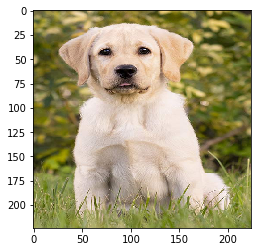

In [211]:
from keras.models import load_model
img = image.load_img(r"website-donate-mobile.jpg" ,target_size = (224, 224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model("vgg16_1.h5")
output = saved_model.predict(img)

if output[0][0] > output[0][1]:
    print("Cat")
else:
    print('Dog')

In [183]:
test_files = glob.glob("cat-and-dog/test_/*.jpg")
test_files

['cat-and-dog/test_/9.jpg',
 'cat-and-dog/test_/1.jpg',
 'cat-and-dog/test_/6.jpg',
 'cat-and-dog/test_/2.jpg',
 'cat-and-dog/test_/3.jpg',
 'cat-and-dog/test_/4.jpg',
 'cat-and-dog/test_/10.jpg',
 'cat-and-dog/test_/5.jpg',
 'cat-and-dog/test_/8.jpg',
 'cat-and-dog/test_/7.jpg']

In [187]:
predictor, image_id = [], []
for i in test_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis = 0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

print([('Dog',j[1]) if j[0] == 0 else ('Cat', j[1]) for j in zip(predictor, image_id)])
output = [('Dog',j[1]) if j[0] == 0 else ('Cat', j[1]) for j in zip(predictor, image_id)]

[('Cat', 'cat-and-dog/test_/9.jpg'), ('Cat', 'cat-and-dog/test_/1.jpg'), ('Cat', 'cat-and-dog/test_/6.jpg'), ('Cat', 'cat-and-dog/test_/2.jpg'), ('Dog', 'cat-and-dog/test_/3.jpg'), ('Cat', 'cat-and-dog/test_/4.jpg'), ('Dog', 'cat-and-dog/test_/10.jpg'), ('Dog', 'cat-and-dog/test_/5.jpg'), ('Dog', 'cat-and-dog/test_/8.jpg'), ('Dog', 'cat-and-dog/test_/7.jpg')]


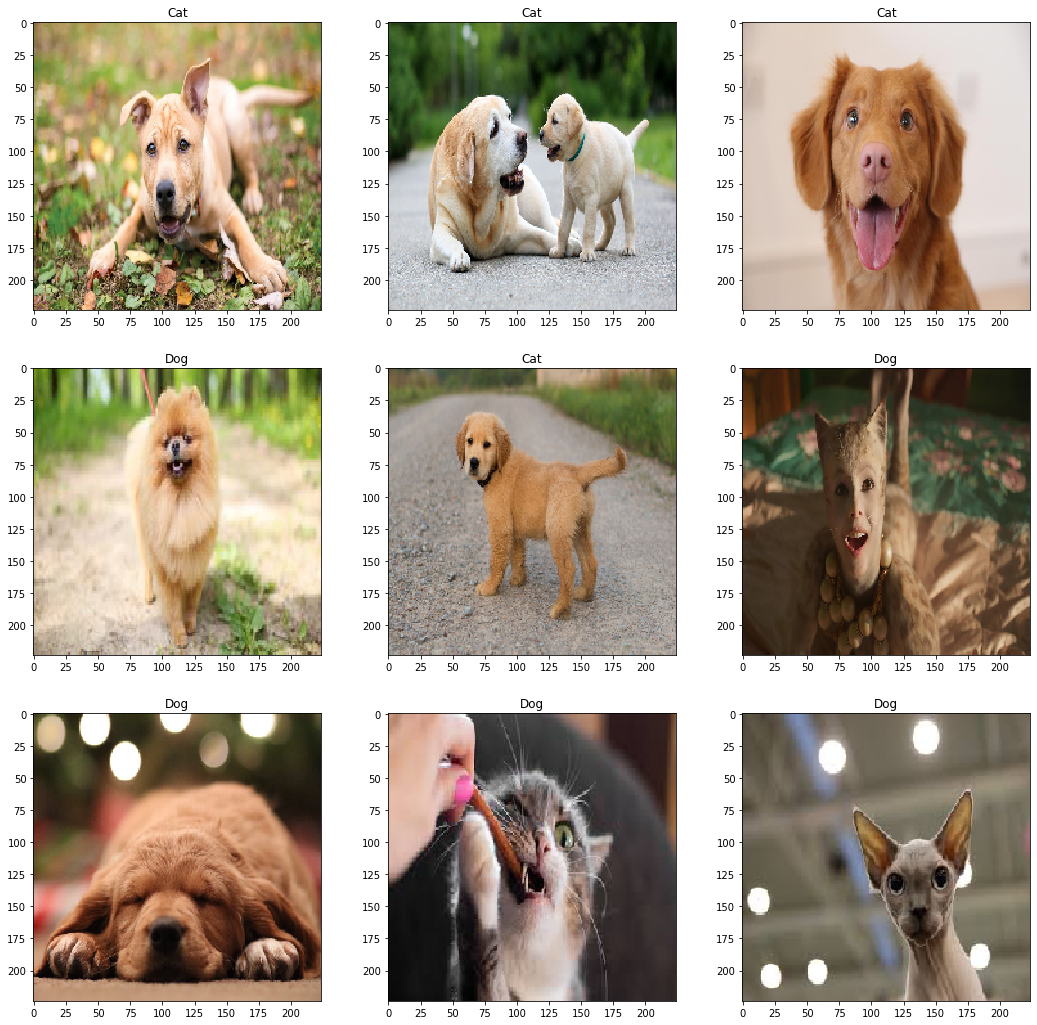

In [190]:
fig=plt.figure(figsize=(18, 18))
columns = 3
rows = 3

for i in range(1, columns*rows + 1):
    img = image.load_img(test_files[i], target_size = (224, 224))
    fig.add_subplot(rows, columns, i)
    plt.title(f'{output[i][0]}')
    plt.imshow(img)
plt.show()